In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
from pathlib import Path
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

from google.colab import files
import seaborn as sns
import zipfile

In [3]:

# ============================================================
# INSTALL DEPENDENCIES
# ============================================================
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu -q
!pip install albumentations scikit-learn matplotlib seaborn tqdm -q

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [4]:
# ============================================================
# SYNTHETIC SHARP IMAGES GENERATION
# ============================================================

def generate_synthetic_sharp_images(num_images=1000, output_dir='./dataset/sharp'):
    """Generate synthetic sharp images to balance dataset"""
    os.makedirs(output_dir, exist_ok=True)

    print(f"Generating {num_images} synthetic sharp images...\n")

    pbar = tqdm(range(num_images), desc="Generating synthetic images")
    for i in pbar:
        # Create a random image with different patterns
        img = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)

        # Add various patterns
        # Random rectangles
        for _ in range(np.random.randint(2, 5)):
            x1, y1 = np.random.randint(0, 200), np.random.randint(0, 200)
            x2, y2 = x1 + np.random.randint(10, 50), y1 + np.random.randint(10, 50)
            color = tuple(np.random.randint(0, 256, 3).tolist())
            cv2.rectangle(img, (x1, y1), (x2, y2), color, -1)

        # Random circles
        for _ in range(np.random.randint(1, 3)):
            center = (np.random.randint(0, 224), np.random.randint(0, 224))
            radius = np.random.randint(10, 50)
            color = tuple(np.random.randint(0, 256, 3).tolist())
            cv2.circle(img, center, radius, color, -1)

        # Random lines
        for _ in range(np.random.randint(2, 5)):
            x1, y1 = np.random.randint(0, 224), np.random.randint(0, 224)
            x2, y2 = np.random.randint(0, 224), np.random.randint(0, 224)
            color = tuple(np.random.randint(0, 256, 3).tolist())
            cv2.line(img, (x1, y1), (x2, y2), color, 2)

        # Add noise
        noise = np.random.normal(0, 15, img.shape)
        img = np.clip(img + noise, 0, 255).astype(np.uint8)

        # Apply slight blur to make it look more realistic
        if np.random.rand() > 0.5:
            kernel_size = np.random.choice([3, 5])
            img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

        # Save image
        img_path = os.path.join(output_dir, f'synthetic_sharp_{i:05d}.jpg')
        cv2.imwrite(img_path, img)

    print(f"\n✓ Generated {num_images} synthetic sharp images\n")

In [5]:
# ============================================================
# CUSTOM DATASET
# ============================================================

class BlurDataset(Dataset):
    """Custom Dataset for Blur Classification"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        if img is None:
            img = np.ones((224, 224, 3), dtype=np.uint8) * 128
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [6]:
# ============================================================
# MODEL ARCHITECTURE
# ============================================================

class BlurDetectionModel(nn.Module):
    """ResNet50 for Blur Detection"""
    def __init__(self, num_classes=2):
        super(BlurDetectionModel, self).__init__()

        # Load pretrained ResNet50
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Replace final layer with custom head
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


In [7]:
# ============================================================
# TRAINER CLASS
# ============================================================

class BlurDetectionTrainer:
    """Trainer for Blur Detection Model"""
    def __init__(self, model, device, learning_rate=0.001):
        self.model = model
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=1e-6)
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        self.best_acc = 0

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc="Training")
        for images, labels in pbar:
            images = images.to(self.device)
            labels = labels.to(self.device)

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({'loss': loss.item()})

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct / total

        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs=50):
        """Complete training loop"""
        patience = 12
        patience_counter = 0

        print("\n" + "="*70)
        print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
        print("="*70)

        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.validate(val_loader)

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} {val_loss:<12.4f} {val_acc:<12.4f}")

            # Learning rate scheduling
            self.scheduler.step()

            # Save best model
            if val_acc > self.best_acc:
                self.best_acc = val_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_blur_detector.pth')
                print("                                                                      ✓ Best model saved")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\n⚠ Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                    break

        print("="*70)
        print("✓ Training complete!")
        return self.history


In [8]:
# ============================================================
# PREDICTION FUNCTION
# ============================================================

def predict_blur(model, image_path, device):
    """Predict if image is blurred"""
    model.eval()

    img = cv2.imread(image_path)
    if img is None:
        return None, 0

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(Image.fromarray(img)).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_class].item()

    return pred_class, confidence

# ============================================================
# MAIN EXECUTION
# ============================================================

print("\n" + "🚀"*10)
print("ResNet50 Blur Detection - Training on 1000 Blur Images + Synthetic Sharp")
print("🚀"*10 + "\n")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}\n")


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
ResNet50 Blur Detection - Training on 1000 Blur Images + Synthetic Sharp
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6



STEP 1: Upload Your 1000 Blur Images

Expected:
  blur_images.zip (containing 1000 blur images)
  OR individual blur image files



Saving motion0001.jpg to motion0001.jpg
Saving motion0002.jpg to motion0002.jpg
Saving motion0003.jpg to motion0003.jpg
Saving motion0004.jpg to motion0004.jpg
Saving motion0005.jpg to motion0005.jpg
Saving motion0006.jpg to motion0006.jpg
Saving motion0007.jpg to motion0007.jpg
Saving motion0008.jpg to motion0008.jpg
Saving motion0009.jpg to motion0009.jpg
Saving motion0010.jpg to motion0010.jpg
Saving motion0011.jpg to motion0011.jpg
Saving motion0012.jpg to motion0012.jpg
Saving motion0013.jpg to motion0013.jpg
Saving motion0014.jpg to motion0014.jpg
Saving motion0015.jpg to motion0015.jpg
Saving motion0016.jpg to motion0016.jpg
Saving motion0017.jpg to motion0017.jpg
Saving motion0018.jpg to motion0018.jpg
Saving motion0019.jpg to motion0019.jpg
Saving motion0020.jpg to motion0020.jpg
Saving motion0021.jpg to motion0021.jpg
Saving motion0022.jpg to motion0022.jpg
Saving motion0023.jpg to motion0023.jpg
Saving motion0024.jpg to motion0024.jpg
Saving motion0025.jpg to motion0025.jpg


Generating synthetic images: 100%|██████████| 1000/1000 [00:11<00:00, 83.90it/s]



✓ Generated 1000 synthetic sharp images

✓ Generated 1000 synthetic sharp images
✓ Total dataset: 1000 blur + 1000 sharp = 2000 images

STEP 3: Preparing Data

Data Split:
  Training:   1400 images (70.0%)
  Validation: 300 images (15.0%)
  Test:       300 images (15.0%)

STEP 4: Creating Data Loaders with Augmentation

✓ Data loaders created
  Batch size: 32
  Train batches: 44
  Val batches: 10
  Test batches: 10

STEP 5: Training ResNet50 Model
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]



Model Parameters:
  Total: 24,690,498
  Trainable: 24,690,498


Epoch    Train Loss   Train Acc    Val Loss     Val Acc     


Training: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s, loss=0.056]


1        0.2032       0.9271       0.0036       1.0000      
                                                                      ✓ Best model saved


Training: 100%|██████████| 44/44 [00:27<00:00,  1.60it/s, loss=0.0141]


2        0.1002       0.9700       0.0016       1.0000      


Training: 100%|██████████| 44/44 [00:28<00:00,  1.57it/s, loss=0.0242]


3        0.0700       0.9807       0.0022       1.0000      


Training: 100%|██████████| 44/44 [00:28<00:00,  1.52it/s, loss=0.00203]


4        0.0860       0.9779       0.0111       1.0000      


Training: 100%|██████████| 44/44 [00:28<00:00,  1.54it/s, loss=0.0953]


5        0.0787       0.9743       0.0017       1.0000      


Training: 100%|██████████| 44/44 [00:29<00:00,  1.51it/s, loss=0.291]


6        0.0459       0.9893       0.0007       1.0000      


Training: 100%|██████████| 44/44 [00:28<00:00,  1.55it/s, loss=0.00138]


7        0.0411       0.9886       0.0008       1.0000      


Training: 100%|██████████| 44/44 [00:27<00:00,  1.59it/s, loss=0.00776]


8        0.0347       0.9857       0.0011       1.0000      


Training: 100%|██████████| 44/44 [00:28<00:00,  1.52it/s, loss=0.00496]


9        0.0277       0.9900       0.0836       0.9533      


Training: 100%|██████████| 44/44 [00:28<00:00,  1.56it/s, loss=0.00521]


10       0.0453       0.9857       0.0064       1.0000      


Training: 100%|██████████| 44/44 [00:27<00:00,  1.61it/s, loss=0.000847]


11       0.0186       0.9957       0.0002       1.0000      


Training: 100%|██████████| 44/44 [00:28<00:00,  1.57it/s, loss=0.000535]


12       0.0095       0.9979       0.0095       0.9967      


Training: 100%|██████████| 44/44 [00:28<00:00,  1.54it/s, loss=0.000741]


13       0.0305       0.9914       0.0003       1.0000      

⚠ Early stopping at epoch 13 (no improvement for 12 epochs)
✓ Training complete!

STEP 6: Model Evaluation on Test Set

Test Loss: 0.0035
Test Accuracy: 1.0000

Classification Report:

              precision    recall  f1-score   support

       Sharp       1.00      1.00      1.00       150
     Blurred       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

STEP 7: Generating Visualizations



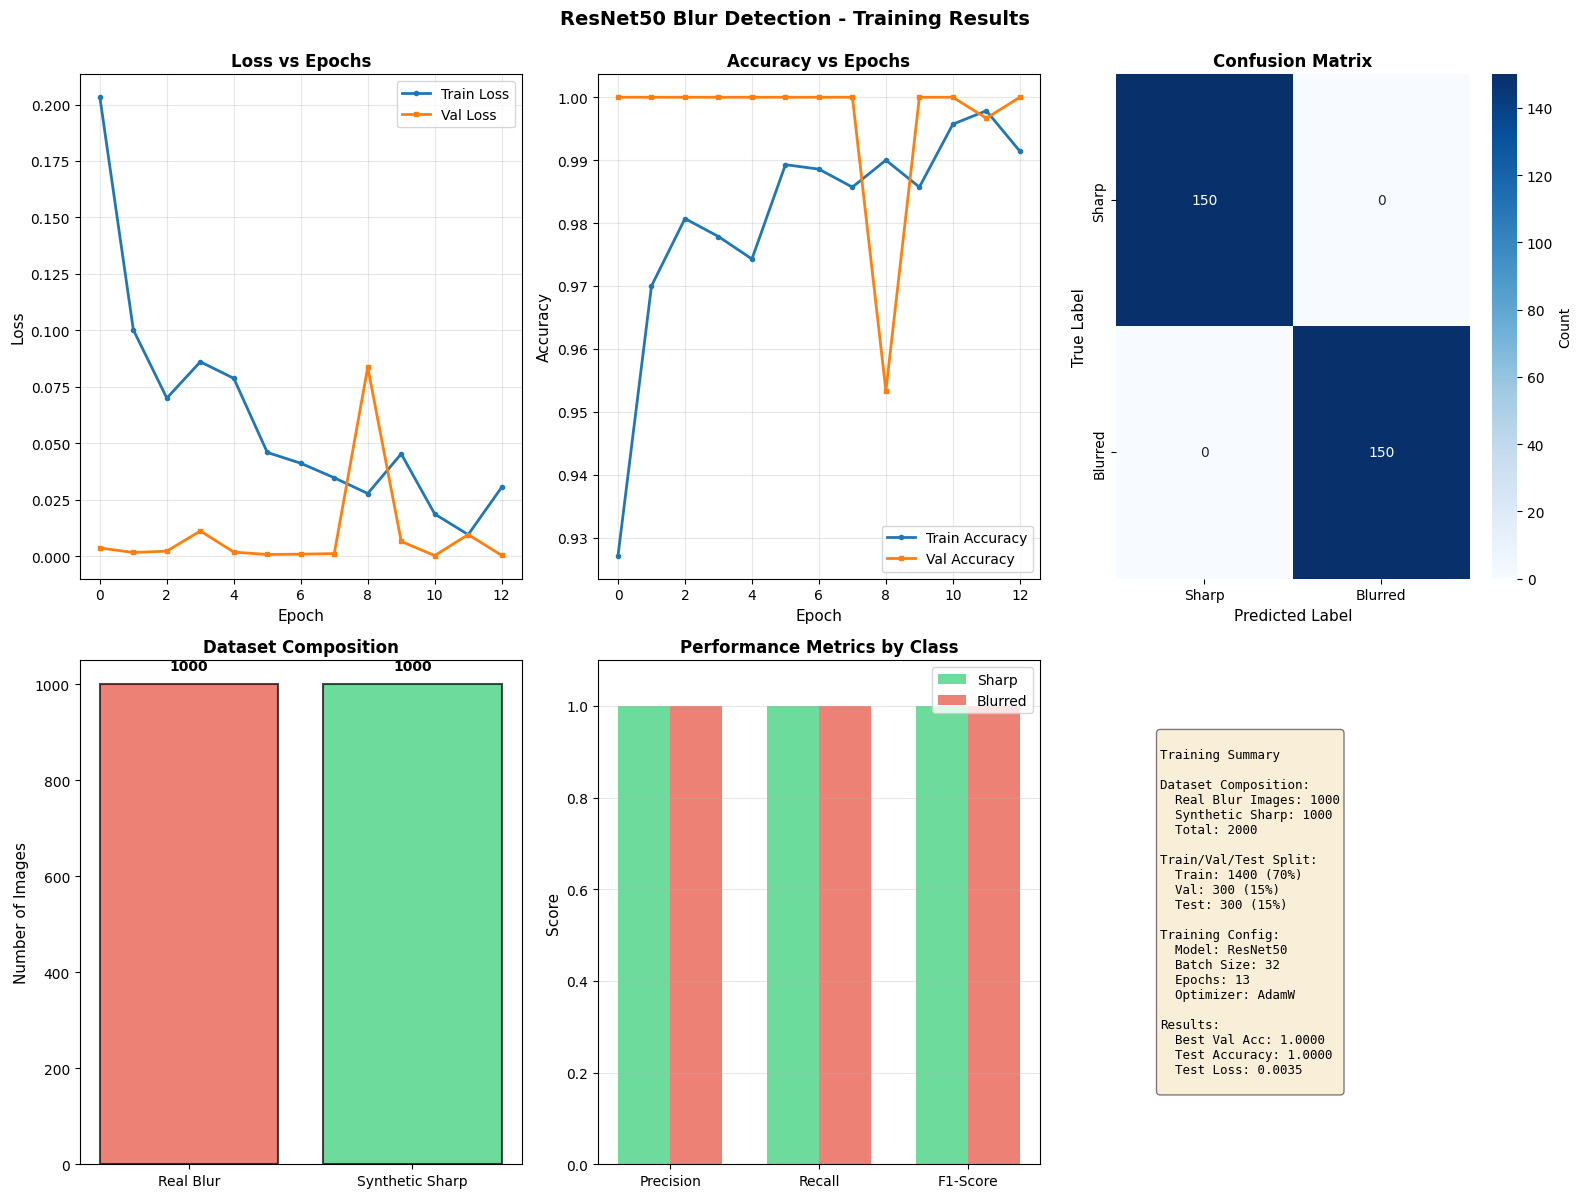

✓ Visualizations saved to training_results.png

STEP 8: Saving Models

✓ Final model saved as 'blur_detector_final.pth'
✓ Model info saved to model_info.json

STEP 9: Test on Your Images

Upload test images to classify:



Saving 0_IPHONE-SE_M.JPG to 0_IPHONE-SE_M.JPG
Saving 1_XIAOMI-PROCOFONE-F1_M.jpg to 1_XIAOMI-PROCOFONE-F1_M.jpg
Saving 2_XIAOMI-PROCOFONE-F1_M.jpg to 2_XIAOMI-PROCOFONE-F1_M.jpg
Saving 3_HUAWEI-NOVA-LITE_M.jpg to 3_HUAWEI-NOVA-LITE_M.jpg
Saving 4_XIAOMI-PROCOFONE-F1_M.jpg to 4_XIAOMI-PROCOFONE-F1_M.jpg
Saving 5_XIAOMI-PROCOFONE-F1_M.jpg to 5_XIAOMI-PROCOFONE-F1_M.jpg
Saving 6_HUAWEI-MATE20_M.jpg to 6_HUAWEI-MATE20_M.jpg
Saving 7_NIKON-D3400-35MM_M.JPG to 7_NIKON-D3400-35MM_M.JPG
Saving 8_SAMSUNG-GALAXY-A6_M.jpg to 8_SAMSUNG-GALAXY-A6_M.jpg
Saving 9_HUAWEI-P20_M.jpg to 9_HUAWEI-P20_M.jpg
Saving 10_ASUS-ZENFONE-LIVE-ZB501KL_M.jpg to 10_ASUS-ZENFONE-LIVE-ZB501KL_M.jpg
Saving 11_XIAOMI-MI8-SE_M.jpg to 11_XIAOMI-MI8-SE_M.jpg
Saving 12_SAMSUNG-GALAXY-J5_M.jpg to 12_SAMSUNG-GALAXY-J5_M.jpg
Saving 13_IPHONE-8-PLUS_M.jpg to 13_IPHONE-8-PLUS_M.jpg
Saving 14_IPHONE-7_M.jpeg to 14_IPHONE-7_M.jpeg
Saving 15_HONOR-7C_M.jpg to 15_HONOR-7C_M.jpg
Saving 16_IPHONE-7_M.jpeg to 16_IPHONE-7_M.jpeg
Saving 1

In [9]:
# ============================================================
# STEP 1: UPLOAD BLUR DATASET
# ============================================================

print("="*70)
print("STEP 1: Upload Your 1000 Blur Images")
print("="*70)
print("\nExpected:")
print("  blur_images.zip (containing 1000 blur images)")
print("  OR individual blur image files\n")

uploaded = files.upload()

os.makedirs('./dataset/blur', exist_ok=True)
os.makedirs('./dataset/sharp', exist_ok=True)

blur_dir = './dataset/blur'
sharp_dir = './dataset/sharp'

# Extract uploaded files
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        print(f"Extracting {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('./dataset')
    else:
        if not filename.endswith('.pth'):
            shutil.copy(filename, blur_dir)

# Count blur images
blur_images = list(Path(blur_dir).glob('*.jpg')) + list(Path(blur_dir).glob('*.png')) + \
              list(Path(blur_dir).glob('*.jpeg')) + list(Path(blur_dir).glob('*.JPG'))

print(f"\n✓ Loaded {len(blur_images)} blur images\n")

# ============================================================
# STEP 2: GENERATE SYNTHETIC SHARP IMAGES
# ============================================================

print("="*70)
print("STEP 2: Generate Synthetic Sharp Images")
print("="*70 + "\n")

# Generate synthetic sharp images to balance dataset
num_synthetic = len(blur_images)
generate_synthetic_sharp_images(num_images=num_synthetic, output_dir=sharp_dir)

# Count sharp images
sharp_images = list(Path(sharp_dir).glob('*.jpg')) + list(Path(sharp_dir).glob('*.png')) + \
               list(Path(sharp_dir).glob('*.jpeg')) + list(Path(sharp_dir).glob('*.JPG'))

print(f"✓ Generated {len(sharp_images)} synthetic sharp images")
print(f"✓ Total dataset: {len(blur_images)} blur + {len(sharp_images)} sharp = {len(blur_images) + len(sharp_images)} images\n")

# ============================================================
# STEP 3: PREPARE DATA
# ============================================================

print("="*70)
print("STEP 3: Preparing Data")
print("="*70)

blur_images = [str(p) for p in blur_images]
sharp_images = [str(p) for p in sharp_images]

X = blur_images + sharp_images
y = [1] * len(blur_images) + [0] * len(sharp_images)

# Split data: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nData Split:")
print(f"  Training:   {len(X_train)} images ({len(X_train)*100//len(X):.1f}%)")
print(f"  Validation: {len(X_val)} images ({len(X_val)*100//len(X):.1f}%)")
print(f"  Test:       {len(X_test)} images ({len(X_test)*100//len(X):.1f}%)\n")

# ============================================================
# STEP 4: CREATE DATA LOADERS WITH AUGMENTATION
# ============================================================

print("="*70)
print("STEP 4: Creating Data Loaders with Augmentation")
print("="*70)

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=25, p=0.6),
    A.GaussNoise(p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.6),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], p=1.0)

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], p=1.0)

# Create datasets
train_dataset = BlurDataset(X_train, y_train, transform=train_transform)
val_dataset = BlurDataset(X_val, y_val, transform=val_transform)
test_dataset = BlurDataset(X_test, y_test, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"\n✓ Data loaders created")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}\n")

# ============================================================
# STEP 5: TRAIN MODEL
# ============================================================

print("="*70)
print("STEP 5: Training ResNet50 Model")
print("="*70)

model = BlurDetectionModel(num_classes=2).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}\n")

trainer = BlurDetectionTrainer(model, device, learning_rate=0.001)

# Train model
history = trainer.train(train_loader, val_loader, num_epochs=60)

# ============================================================
# STEP 6: EVALUATE
# ============================================================

print("\n" + "="*70)
print("STEP 6: Model Evaluation on Test Set")
print("="*70)

model.load_state_dict(torch.load('best_blur_detector.pth'))
model.eval()

test_loss, test_acc = trainer.validate(test_loader)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Get predictions for detailed metrics
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n" + "="*70)
print("Classification Report:")
print("="*70 + "\n")
print(classification_report(all_labels, all_preds, target_names=['Sharp', 'Blurred']))

# ============================================================
# STEP 7: VISUALIZE RESULTS
# ============================================================

print("="*70)
print("STEP 7: Generating Visualizations")
print("="*70 + "\n")

fig = plt.figure(figsize=(16, 12))

# Loss plot
ax1 = plt.subplot(2, 3, 1)
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=3)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=3)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Loss vs Epochs', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2 = plt.subplot(2, 3, 2)
ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2, marker='o', markersize=3)
ax2.plot(history['val_acc'], label='Val Accuracy', linewidth=2, marker='s', markersize=3)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Accuracy vs Epochs', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Confusion matrix
ax3 = plt.subplot(2, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Sharp', 'Blurred'], yticklabels=['Sharp', 'Blurred'],
            cbar_kws={'label': 'Count'})
ax3.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=11)
ax3.set_xlabel('Predicted Label', fontsize=11)

# Class distribution
ax4 = plt.subplot(2, 3, 4)
classes = ['Real Blur', 'Synthetic Sharp']
counts = [len(blur_images), len(sharp_images)]
colors = ['#e74c3c', '#2ecc71']
ax4.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_title('Dataset Composition', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Images', fontsize=11)
for i, (cls, count) in enumerate(zip(classes, counts)):
    ax4.text(i, count + 30, str(count), ha='center', fontweight='bold')

# Per-class accuracy
ax5 = plt.subplot(2, 3, 5)
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds)
metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35
ax5.bar(x - width/2, [precision[0], recall[0], f1[0]], width, label='Sharp', color='#2ecc71', alpha=0.7)
ax5.bar(x + width/2, [precision[1], recall[1], f1[1]], width, label='Blurred', color='#e74c3c', alpha=0.7)
ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Performance Metrics by Class', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(metrics)
ax5.legend()
ax5.set_ylim([0, 1.1])
ax5.grid(True, alpha=0.3, axis='y')

# Training info
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
info_text = f"""
Training Summary

Dataset Composition:
  Real Blur Images: {len(blur_images)}
  Synthetic Sharp: {len(sharp_images)}
  Total: {len(X)}

Train/Val/Test Split:
  Train: {len(X_train)} ({len(X_train)*100//len(X)}%)
  Val: {len(X_val)} ({len(X_val)*100//len(X)}%)
  Test: {len(X_test)} ({len(X_test)*100//len(X)}%)

Training Config:
  Model: ResNet50
  Batch Size: {batch_size}
  Epochs: {len(history['train_loss'])}
  Optimizer: AdamW

Results:
  Best Val Acc: {max(history['val_acc']):.4f}
  Test Accuracy: {test_acc:.4f}
  Test Loss: {test_loss:.4f}
"""
ax6.text(0.1, 0.5, info_text, fontsize=9, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('ResNet50 Blur Detection - Training Results', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('training_results.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved to training_results.png\n")

# ============================================================
# STEP 8: SAVE MODELS
# ============================================================

print("="*70)
print("STEP 8: Saving Models")
print("="*70 + "\n")

torch.save(model.state_dict(), 'blur_detector_final.pth')
print("✓ Final model saved as 'blur_detector_final.pth'")

# Save model info
model_info = {
    'model_name': 'ResNet50 Blur Detector',
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'best_val_accuracy': float(max(history['val_acc'])),
    'num_classes': 2,
    'class_names': ['Sharp', 'Blurred'],
    'training_data': {
        'real_blur_images': len(blur_images),
        'synthetic_sharp_images': len(sharp_images),
        'total_images': len(X)
    },
    'epochs_trained': len(history['train_loss'])
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("✓ Model info saved to model_info.json\n")

# ============================================================
# STEP 9: TEST ON NEW IMAGES
# ============================================================

print("="*70)
print("STEP 9: Test on Your Images")
print("="*70)
print("\nUpload test images to classify:\n")

uploaded_test = files.upload()

os.makedirs('./test_images', exist_ok=True)
for filename in uploaded_test.keys():
    if not filename.endswith(('.pth', '.json', '.png')):
        shutil.copy(filename, './test_images/')

test_image_paths = list(Path('./test_images').glob('*'))
test_image_paths = [p for p in test_image_paths if p.suffix.lower() in ['.jpg', '.png', '.jpeg', '.bmp']]

if len(test_image_paths) > 0:
    print(f"\nTesting on {len(test_image_paths)} images:\n")
    print(f"{'Filename':<35} {'Prediction':<15} {'Confidence':<12}")
    print("-" * 65)

    for img_path in sorted(test_image_paths):
        pred_class, confidence = predict_blur(model, str(img_path), device)
        if pred_class is not None:
            class_name = "🔴 BLURRED" if pred_class == 1 else "🟢 SHARP"
            print(f"{img_path.name:<35} {class_name:<15} {confidence:.4f}")
else:
    print("No test images uploaded")

print("\n" + "="*70)
print("✅ Training Complete!")
print("="*70)
print("\n✓ Download these files:")
print("  - blur_detector_final.pth (model weights)")
print("  - model_info.json (model metadata)")
print("  - training_results.png (visualization)\n")

In [1]:
# ============================================================
# STEP 8: SAVE MODELS
# ============================================================

print("="*70)
print("STEP 8: Saving Models")
print("="*70 + "\n")

torch.save(model.state_dict(), 'blur_detector_final.pth')
print("✓ Final model saved as 'blur_detector_final.pth'")

# Save model info
model_info = {
    'model_name': 'ResNet50 Blur Detector',
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'best_val_accuracy': float(max(history['val_acc'])),
    'num_classes': 2,
    'class_names': ['Sharp', 'Blurred'],
    'training_data': {
        'real_blur_images': len(blur_images),
        'synthetic_sharp_images': len(sharp_images),
        'total_images': len(X)
    },
    'epochs_trained': len(history['train_loss'])
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("✓ Model info saved to model_info.json\n")


STEP 8: Saving Models



NameError: name 'torch' is not defined